## Loads pre-trained model and get prediction on validation samples

### 1. Info
Please provide path to the relevant config file

In [1]:
config_file_path = "../configs/config.json"

### 2. Importing required modules

In [40]:
import os
import cv2
import json
import sys
import importlib
import torch
import numpy as np
import glob
import matplotlib.pyplot as plt
import time

sys.path.insert(0, "../")
%matplotlib inline

In [3]:
from torchvision.transforms import *
from data_parser import JpegDataset
from data_loader import VideoFolder
from model import ConvColumn
from utils import remove_module_from_checkpoint_state_dict

### 3. Loading configuration file, model definition and its path¶

In [4]:
# load config file
with open(config_file_path) as data_file:
    config = json.load(data_file)

In [5]:
# checkpoint path to a trained model
checkpoint_path = os.path.join("../", config["output_dir"], config["model_name"], "model_best.pth.tar")
print("=> Checkpoint path --> {}".format(checkpoint_path))
assert(os.path.isfile(checkpoint_path))

=> Checkpoint path --> ../trainings/jpeg_model/jester_conv_example/model_best.pth.tar


### 3. Load model
Note: without cuda() for ease

In [6]:
model = ConvColumn(config['num_classes'])
model.eval();

In [7]:
model

ConvColumn(
  (conv_layer1): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer2): Sequential(
    (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer3): Sequential(
    (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False

In [8]:
print("=> loading checkpoint")
checkpoint = torch.load(checkpoint_path)
checkpoint['state_dict'] = remove_module_from_checkpoint_state_dict(
                                              checkpoint['state_dict'])
model.load_state_dict(checkpoint['state_dict'])
print("=> loaded checkpoint '{}' (epoch {})"
      .format(checkpoint_path, checkpoint['epoch']))

=> loading checkpoint
=> loaded checkpoint '../trainings/jpeg_model/jester_conv_example/model_best.pth.tar' (epoch 38)


### 4. Load Data

In [15]:
transform = Compose([
    CenterCrop(84),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
])

val_data = VideoFolder(root=config['val_data_folder'],
                       csv_file_input=config['val_data_csv'],
                       csv_file_labels=config['labels_csv'],
                       clip_size=config['clip_size'],
                       nclips=1,
                       step_size=config['step_size'],
                       is_val=True,
                       transform=transform,
                       )
dict_two_way = val_data.classes_dict

### 5. Get predictions
##### 5.1. Select random sample (or specify the index)

In [108]:
selected_indx = np.random.randint(len(val_data))
# selected_indx = 136

### 5.2 Get data in required format

In [109]:
input_data, target, item_id = val_data[selected_indx]
input_data = input_data.unsqueeze(0)
print("Id of the video sample = {}".format(item_id))
print("True label --> {} ({})".format(target, dict_two_way[target]))

Id of the video sample = 78103
True label --> 13 (Rolling Hand Backward)


### 5.3 Compute output from the model

In [110]:
output = model(input_data).squeeze(0)
output = torch.nn.functional.softmax(output, dim=0)

In [111]:
# compute top5 predictions
pred_prob, pred_top5 = output.data.topk(5)
pred_prob = pred_prob.numpy()
pred_top5 = pred_top5.numpy()

In [112]:
print("Id of the video sample = {}".format(item_id))
print("True label --> {} ({})".format(target, dict_two_way[target]))
print("\nTop-5 Predictions:")
for i, pred in enumerate(pred_top5):
    print("Top {} :== {}. Prob := {:.2f}%".format(i + 1, dict_two_way[pred], pred_prob[i] * 100))

Id of the video sample = 78103
True label --> 13 (Rolling Hand Backward)

Top-5 Predictions:
Top 1 :== Rolling Hand Backward. Prob := 99.97%
Top 2 :== Rolling Hand Forward. Prob := 0.03%
Top 3 :== Zooming Out With Full Hand. Prob := 0.00%
Top 4 :== Drumming Fingers. Prob := 0.00%
Top 5 :== Swiping Right. Prob := 0.00%


In [113]:
path_to_jpegs = sorted(glob.glob(os.path.join(config["val_data_folder"], item_id, "*")))

In [114]:
i = 0

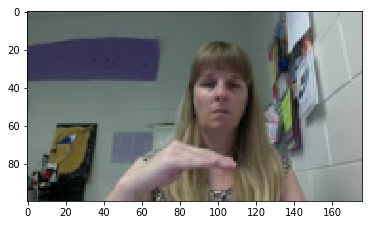

In [139]:
# execute this cell again-and-again to plot images of the video one after another
plt.imshow(plt.imread(path_to_jpegs[i]))
i += 1